In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

# Text Pre-Processing
from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Tools for building a model
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tools for assessing the quality of model prediction
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Colab Notebooks/電影評論情緒分析'
os.chdir(data_path)

df = pd.read_csv(os.path.join(data_path, 'train.csv'))
df_test = pd.read_csv(os.path.join(data_path, 'test.csv'))

Mounted at /content/drive


### Data overview

* check data

In [ ]:
print(df.shape)
print('')
print('-'*70)
display(df.head())
print('')
print('-'*70)
df.info()

(23472, 3)

----------------------------------------------------------------------


,ID,review,sentiment
0,6132,It 's makes a better travelogue than movie .,0
1,36193,This is a sad film made for sad people. I was ...,0
2,15959,This is definitely a good movie unlike what ot...,1
3,13250,The first step to getting off of that road tha...,1
4,42378,This was just another marvelous film of the Be...,1



----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23472 entries, 0 to 23471
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         23472 non-null  int64 
 1   review     23472 non-null  object
 2   sentiment  23472 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 550.2+ KB


*  Missing value check

In [ ]:
df.isna().sum()

ID           0
review       0
sentiment    0
dtype: int64

* Duplicated values check

In [ ]:
print('Number of duplicated values in dataset: ', df.duplicated().sum())

Number of duplicated values in dataset:  0


* Target variable

1    11963
0    11509
Name: sentiment, dtype: int64


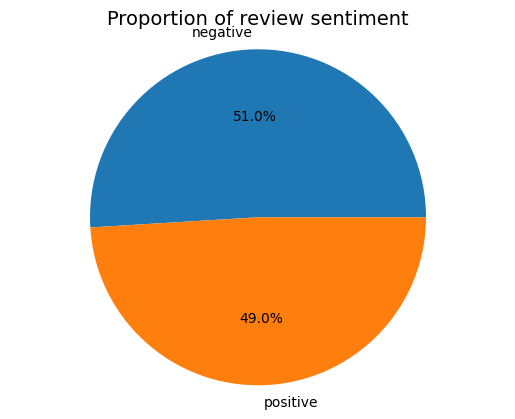

In [ ]:
target = df['sentiment'].value_counts()
print(target)

fig1, ax1 = plt.subplots()
ax1.pie(target, radius=1.5, labels=['negative', 'positive'], autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Proportion of review sentiment", fontsize=14)
plt.show()

## Text Pre-Processing

In [ ]:
# function : text pre-processing
def preprocess_text(sen):
    # Remove HTTP links/URLs
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', ' ', sen)
    # Removing html tags
    text =  BeautifulSoup(text, 'html.parser').get_text()
    # Remove punctuations and numbers
    text = re.sub('[^A-Za-z]', ' ', text)
    # Lower words and splitting
    text = text.lower().split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    # stem words
    text = [WordNetLemmatizer().lemmatize(word) for word in text]

    # Reconcatenate into string
    text = ' '.join(text)
    return(text)

# Execute the function on the data
df['preprocess'] = df['review'].apply(preprocess_text)
df_test['preprocess'] = df_test['review'].apply(preprocess_text)

### Split train data into training set / validation set

In [ ]:
# Split train data into training set / validation set
df_train, df_val = train_test_split(df, test_size=0.1, stratify=df['sentiment'], shuffle=True, random_state=42)

### Create a vocabulary index :

In [ ]:
# Use the result as a reference for max_len
print('The mean word count in a movie review :', df_train['preprocess'].apply(lambda x: len(x.split(' '))).mean())

The mean word count in a movie review : 101.56229880704412


In [ ]:
max_features = 6000  # the total number of unique words in the dataset
max_len = 110   # the maximum number of words we are considering per review

# Tokenize Text :
token = Tokenizer(num_words = max_features, oov_token='OOV')
token.fit_on_texts(df_train['preprocess'])

# Converting text to sequences
x_train_seq = token.texts_to_sequences(df_train['preprocess'])
x_val_seq = token.texts_to_sequences(df_val['preprocess'])
x_test_seq = token.texts_to_sequences(df_test['preprocess'])

# sequence padding
x_train = pad_sequences(x_train_seq, maxlen = max_len, padding='post')
x_val = pad_sequences(x_val_seq,  maxlen = max_len)
x_test = pad_sequences(x_test_seq,  maxlen = max_len)


y_train = df_train['sentiment'].values
y_val = df_val['sentiment'].values
y_test = df_test['sentiment'].values

## Modeling & Training


##### Function

In [ ]:
# function :  Accuracy and loss for training and validation
def plot_performance(epochs, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Training and Validation Loss')
    plt.show()


# Evaluate function
def evaluate(model, x_test, y_test):
  y_pred = model.predict(x_test)
  y_pred_label = (y_pred > 0.5)
  print('----- Model Evaluation -----')
  print('Confusion Matrix:')
  print(confusion_matrix(y_test, y_pred_label))
  print('  ')
  print(classification_report(y_test, y_pred_label))
  print('  ')
  print('---------------------')
  print('  ')
  print('AUC: {0}'.format(roc_auc_score(y_test, y_pred_label)))
  print('F1 score: {0}'.format(f1_score(y_test, y_pred_label)))
  print('Precision: {0}'.format(precision_score(y_test, y_pred_label)))
  print('Recall: {0}'.format(recall_score(y_test, y_pred_label)))
  print('Accuracy: {0}'.format(accuracy_score(y_test, y_pred_label, normalize=True)))

### LSTM

#### (1) Original

*  Construct LSTM model  

  (create Embeddings from scratch)



In [ ]:
embed_dim=100
max_features = 6000  # the total number of unique words in the dataset
max_len = 110
model_LSTM_1 = Sequential(
    [
      Embedding(input_dim = max_features, output_dim = embed_dim, input_length = max_len),
      SpatialDropout1D(0.25),
      LSTM(128, return_sequences = True),
      GlobalMaxPool1D(),
      Dropout(0.3),
      Dense(30, activation="relu"),
      Dropout(0.3),
      Dense(1, activation="sigmoid")
    ]
)

model_LSTM_1.compile(loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy'])

# model structure
#model_LSTM_1.summary()

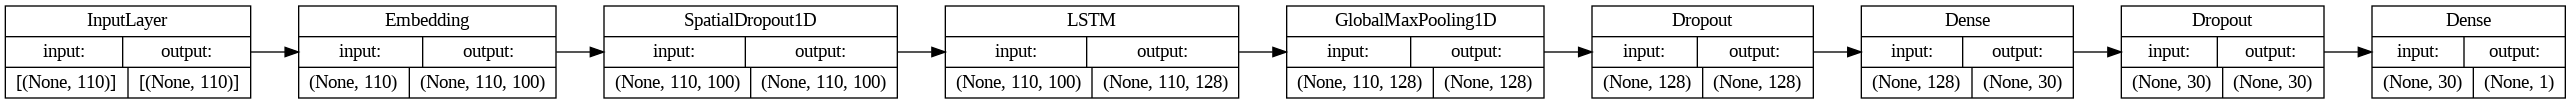

In [ ]:
from keras.utils import plot_model
import pydot

# 繪製模型結構圖
plot_model(model_LSTM_1, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='LR')

* Training

In [ ]:
batch_size = 128
epochs = 20
history_LSTM_1 = model_LSTM_1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/20
166/166 [==============================] - 23s 125ms/step - loss: 0.6049 - accuracy: 0.6735 - val_loss: 0.4991 - val_accuracy: 0.7862
Epoch 2/20
166/166 [==============================] - 9s 52ms/step - loss: 0.3709 - accuracy: 0.8459 - val_loss: 0.3721 - val_accuracy: 0.8437
Epoch 3/20
166/166 [==============================] - 8s 49ms/step - loss: 0.2864 - accuracy: 0.8857 - val_loss: 0.3844 - val_accuracy: 0.8284
Epoch 4/20
166/166 [==============================] - 6s 35ms/step - loss: 0.2451 - accuracy: 0.9030 - val_loss: 0.4148 - val_accuracy: 0.8322
Epoch 5/20
166/166 [==============================] - 6s 35ms/step - loss: 0.2129 - accuracy: 0.9190 - val_loss: 0.4102 - val_accuracy: 0.8352
Epoch 6/20
166/166 [==============================] - 3s 18ms/step - loss: 0.1824 - accuracy: 0.9326 - val_loss: 0.4321 - val_accuracy: 0.8250
Epoch 7/20
166/166 [==============================] - 3s 20ms/step - loss: 0.1628 - accuracy: 0.9394 - val_loss: 0.4849 - val_accuracy: 0.80

* Accuracy and loss for training and validation

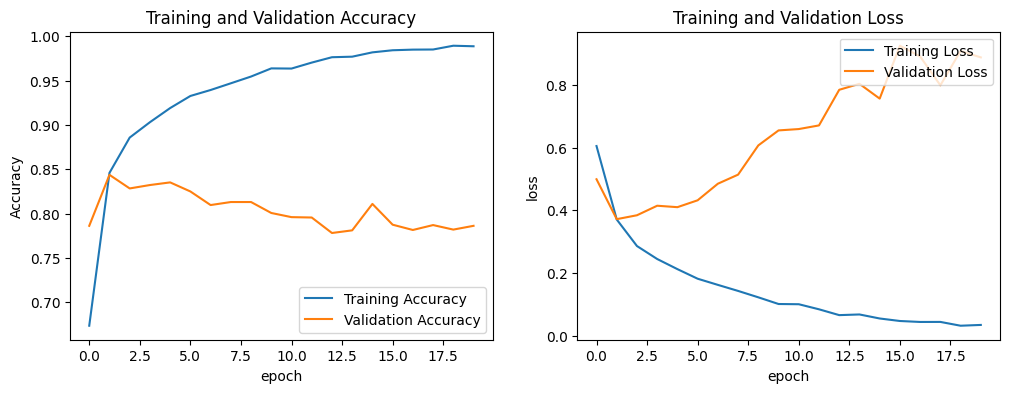

In [ ]:
plot_performance(history_LSTM_1.epoch, history_LSTM_1)

* Test data 預測/評估

In [ ]:
evaluate(model_LSTM_1, x_test, y_test)

184/184 [==============================] - 1s 3ms/step
----- Model Evaluation -----
Confusion Matrix:
[[2331  547]
 [ 668 2323]]
  
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      2878
           1       0.81      0.78      0.79      2991

    accuracy                           0.79      5869
   macro avg       0.79      0.79      0.79      5869
weighted avg       0.79      0.79      0.79      5869

  
---------------------
  
AUC: 0.7933003899351518
F1 score: 0.7926974918955808
Precision: 0.8094076655052265
Recall: 0.7766633233032431
Accuracy: 0.7929800647469757


#### (2) Original + Earlystop

*  Construct LSTM model


In [ ]:
model_LSTM_2 = Sequential(
    [
      Embedding(input_dim = max_features, output_dim = embed_dim, input_length = max_len),
      SpatialDropout1D(0.25),
      LSTM(128, return_sequences = True),
      GlobalMaxPool1D(),
      Dropout(0.3),
      Dense(30, activation="relu"),
      Dropout(0.3),
      Dense(1, activation="sigmoid")
    ]
)


model_LSTM_2.compile(loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss", mode='min', patience=2, restore_best_weights=True)

# model structure
#model_LSTM_2.summary()

* Training

In [ ]:
history_LSTM_2 = model_LSTM_2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks = [callback])

Epoch 1/20
166/166 [==============================] - 22s 116ms/step - loss: 0.6718 - accuracy: 0.5770 - val_loss: 0.6875 - val_accuracy: 0.5213
Epoch 2/20
166/166 [==============================] - 11s 67ms/step - loss: 0.6507 - accuracy: 0.6219 - val_loss: 0.6451 - val_accuracy: 0.6844
Epoch 3/20
166/166 [==============================] - 7s 45ms/step - loss: 0.4718 - accuracy: 0.7898 - val_loss: 0.3914 - val_accuracy: 0.8250
Epoch 4/20
166/166 [==============================] - 6s 34ms/step - loss: 0.3144 - accuracy: 0.8728 - val_loss: 0.3813 - val_accuracy: 0.8313
Epoch 5/20
166/166 [==============================] - 4s 27ms/step - loss: 0.2599 - accuracy: 0.8974 - val_loss: 0.4045 - val_accuracy: 0.8271
Epoch 6/20
166/166 [==============================] - 4s 26ms/step - loss: 0.2196 - accuracy: 0.9173 - val_loss: 0.4464 - val_accuracy: 0.8258


* Accuracy and loss for training and validation

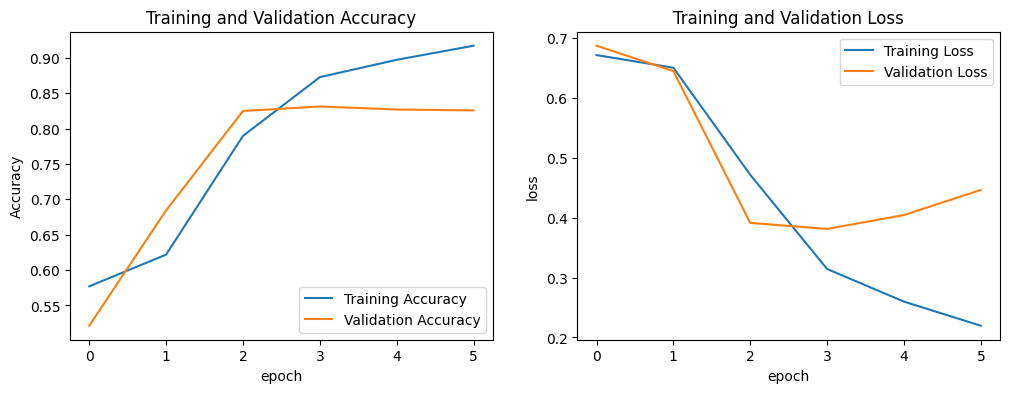

In [ ]:
plot_performance(history_LSTM_2.epoch, history_LSTM_2)

* Test data 預測/評估

In [ ]:
evaluate(model_LSTM_2, x_test, y_test)

184/184 [==============================] - 1s 4ms/step
----- Model Evaluation -----
Confusion Matrix:
[[2453  425]
 [ 527 2464]]
  
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      2878
           1       0.85      0.82      0.84      2991

    accuracy                           0.84      5869
   macro avg       0.84      0.84      0.84      5869
weighted avg       0.84      0.84      0.84      5869

  
---------------------
  
AUC: 0.8380663765677389
F1 score: 0.838095238095238
Precision: 0.8528902734510211
Recall: 0.8238047475760615
Accuracy: 0.8377917873573011


#### (3) BiLSTM

*  Construct BiLSTM model


In [ ]:
model_BiLSTM = Sequential(
    [
      Embedding(input_dim = max_features, output_dim = embed_dim, input_length = max_len),
      SpatialDropout1D(0.25),
      Bidirectional(LSTM(128, return_sequences = True)),
      GlobalMaxPool1D(),
      Dropout(0.3),
      Dense(30, activation="relu"),
      Dropout(0.3),
      Dense(1, activation="sigmoid")
    ]
)


model_BiLSTM.compile(loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy'])

callback = EarlyStopping(monitor="val_loss", mode='min', patience=2, restore_best_weights=True)

# model structure
#model_BiLSTM.summary()

* Training

In [ ]:
history_BiLSTM = model_BiLSTM.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), callbacks = [callback])

Epoch 1/20
166/166 [==============================] - 26s 130ms/step - loss: 0.5167 - accuracy: 0.7280 - val_loss: 0.3759 - val_accuracy: 0.8356
Epoch 2/20
166/166 [==============================] - 10s 60ms/step - loss: 0.3172 - accuracy: 0.8657 - val_loss: 0.3450 - val_accuracy: 0.8565
Epoch 3/20
166/166 [==============================] - 8s 48ms/step - loss: 0.2583 - accuracy: 0.8973 - val_loss: 0.3607 - val_accuracy: 0.8433
Epoch 4/20
166/166 [==============================] - 8s 49ms/step - loss: 0.2256 - accuracy: 0.9127 - val_loss: 0.3735 - val_accuracy: 0.8399


* Accuracy and loss for training and validation

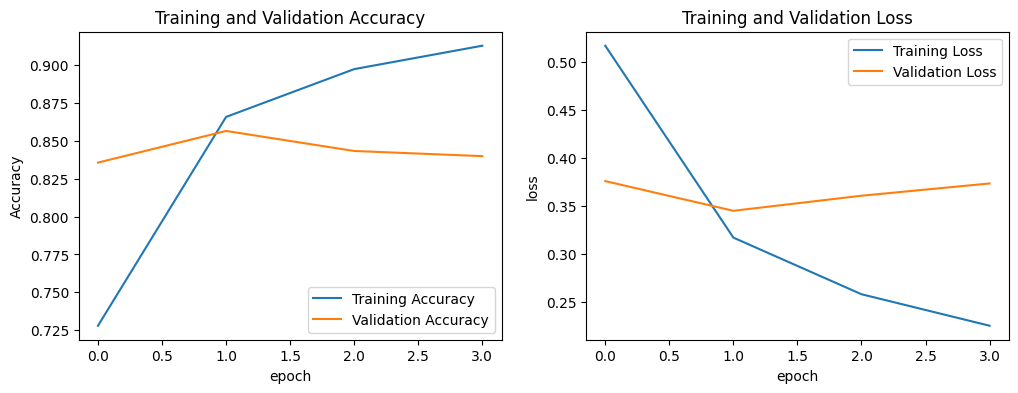

In [ ]:
plot_performance(history_BiLSTM.epoch, history_BiLSTM)

* Test data 預測/評估

In [ ]:
evaluate(model_BiLSTM, x_test, y_test)

184/184 [==============================] - 2s 7ms/step
----- Model Evaluation -----
Confusion Matrix:
[[2463  415]
 [ 510 2481]]
  
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      2878
           1       0.86      0.83      0.84      2991

    accuracy                           0.84      5869
   macro avg       0.84      0.84      0.84      5869
weighted avg       0.84      0.84      0.84      5869

  
---------------------
  
AUC: 0.8426455530594564
F1 score: 0.8428741294377442
Precision: 0.8566988950276243
Recall: 0.8294884653961886
Accuracy: 0.8423922303629239
